In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import copy
import os

import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch import optim
from tqdm import tqdm
import logging
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
from modules import UNet, EMA
from utils import setup_logging, get_data, save_images, plot_images
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
from ddpm import Diffusion
from utils import get_data

In [34]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [21]:
num_classes = 10
device = "cpu"
model = UNet(num_classes=num_classes).to(device)
diffusion = Diffusion(img_size=64, device=device)

In [8]:
datadir = "/mnt/Data/Datasets/Images/CIFAR10/cifar10-64/"
train_path = os.path.join(datadir, "train")
val_path = os.path.join(datadir, "test")
train_dataloader = get_data(train_path, 4, img_size=64)
val_dataloader = get_data(val_path, 4, img_size=64)

In [17]:
X, y = next(iter(train_dataloader))

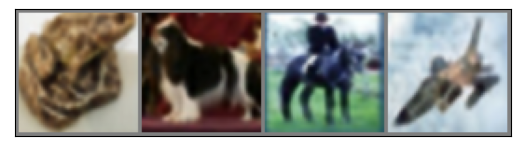

In [37]:
unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
show(unorm(make_grid(X)))

In [40]:
t = diffusion.sample_timestepss(4).to(device)
x_t, noise = diffusion.noise_image(X, t)

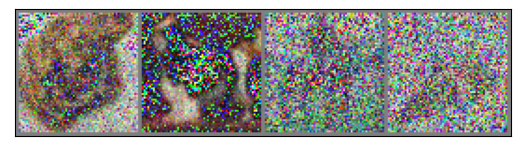

In [41]:
show(unorm(make_grid(x_t)))

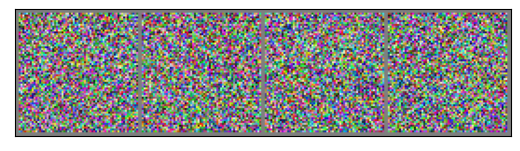

In [46]:
show(unorm(make_grid(noise)))

In [49]:
from ddpm import train
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--epochs', type=int, default=500, help='Number of epochs')
parser.add_argument('--batch_size', type=int, default=12, help='Batch size')
parser.add_argument('--image_size', type=int, default=64, help='Image size')
parser.add_argument('--dataset', type=str, default="data", help='Path to dataset')
parser.add_argument('--device', type=str, default="cpu", choices=["cuda", "cpu"], help='Path to dataset')
parser.add_argument('--lr', type=float, default=3e-4, help='Learning rate')
parser.add_argument('--num_classes', type=int, default=None, help='Number of classes in dataset')

args = parser.parse_args()



usage: ipykernel_launcher.py [-h] [--epochs EPOCHS] [--batch_size BATCH_SIZE]
                             [--image_size IMAGE_SIZE] [--dataset DATASET]
                             [--device {cuda,cpu}] [--lr LR]
                             [--num_classes NUM_CLASSES]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/alex/.local/share/jupyter/runtime/kernel-b141d34c-dc75-41df-8f68-0a3e14e65a72.json


SystemExit: 2

In [ ]:
args.run_name = "DDPM_Unconditional"
args.epochs = 500
args.batch_size = 12
args.image_size = 64
args.dataset_path = datadir
args.device = "cpu"
args.lr = 3e-4
train(args)
